In [1]:
import os
import coastalcf as clf
from esa_snappy import ProductIO, GPF
from esa_snappy import GPF, HashMap, jpy
import numpy as np

---------------------------------------------------------------------------
***************************************************************************
---------------------------------------------------------------------------
//////////////////        PREPARACIÓN DE LOS DATOS        /////////////////
---------------------------------------------------------------------------
***************************************************************************
---------------------------------------------------------------------------

In [2]:
# --- 1. Define la región de interés (ROI) para el subconjunto y la ruta del producto.
# Si no existew substet colocar None
# x = y = width = height = None
#Inicio de la región de interés (ROI) en coordenadas de píxeles.
x=32
y = 14091
#Final de la región de interés (ROI) en coordenadas de píxeles.
width = 1355
height = 897
#x = y = width = height = None

# Defininir parámetros para el operador GLCM.
para = {'sourceBands': 'VH'}

# Path del Producto de Sentinel 1 y ouput de archivos.

sentinel_1_path = r'C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\S1A_IW_GRDH_1SDV_20230607T130609_20230607T130634_048880_05E0CE_1909'
sentinel_id = clf.get_sentinel_fecha_id(sentinel_1_path)
output_directory = r'C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio'
output_directorysh = r'C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio\shape'


---------------------------------------------------------------------------
***************************************************************************
---------------------------------------------------------------------------
///////////////// APLICACIÓN DE LOS PASOS DE PROCESAMIENTO ////////////////
---------------------------------------------------------------------------
***************************************************************************
---------------------------------------------------------------------------

In [3]:
# --- 1. Lectura de metadatos del producto Sentinel-1 ---
product = clf.readMetadata(sentinel_1_path, toPrint=True)  

# --- 2. Eliminación de ruido térmico : do_thermal_noise_removal [output]---
thermaremoved = clf.do_thermal_noise_removal(product)
if thermaremoved is None:
    raise RuntimeError("Thermal noise removal failed.")
print(f"Bands after ThermalNoiseRemoval: {list(thermaremoved.getBandNames())}")
#**************************************************************************
# --- 3. Calibración radiométrica : radiometricCalibration [calibrated] ---
calibrate = clf.radiometricCalibration(thermaremoved)
if calibrate is None:
    raise RuntimeError("Radiometric calibration failed.")
print(f"Bands after RadiometricCalibration: {list(calibrate.getBandNames())}")

# - Verificar las bandas después de la calibración
valid_bands = list(calibrate.getBandNames())
print(f" Bandas disponibles después de la calibración: {valid_bands}")

# - Asegurar que usamos solo las bandas que existen
subset_bands = [band for band in ['Sigma0_VH', 'Sigma0_VV', 'Beta0_VH', 'Beta0_VV'] if band in valid_bands]
if not subset_bands:
    raise RuntimeError("No existen Bandas válidas para el subset.")
# ---
# --- Paso 3.1: Crear el subset después de calibrar ---

subset_product = clf.subset(calibrate, x, y, width, height, subset_bands)

# - Validar subset antes de continuar
if subset_product is None or subset_product.getSceneRasterWidth() == 0 or subset_product.getSceneRasterHeight() == 0:
    raise RuntimeError("Error: El subset no contiene datos válidos.")

print(f" Subset creado correctamente con bandas: {list(subset_product.getBandNames())}")
print(subset_product.getMetadataRoot().toString())
#**************************************************************************
# --- 4. Aplicación de multilooking : perform_multilook [multilook]
print("Performing multilooking...")
#multilook = perform_multilook(calibrate)
multilook = clf.perform_multilook(subset_product)
if multilook is None:
    raise RuntimeError("Multilooking failed.")
#**************************************************************************
# --- 5. Filtrado de speckle : speckleFiltering [speckle]
print("Applying speckle filtering...")
speckle = clf.speckleFiltering(multilook, toPrint=True)
if speckle is None:
    raise RuntimeError("Speckle filtering failed.")


#**************************************************************************
# --- 6. Nivelación del terreno (Terrain Flattening) : perform_terrain_flattening [terrain]
print("Applying terrain flattening...")
terrain1 = clf.perform_terrain_flattening(speckle)
if terrain1 is None:
    raise RuntimeError("Terrain flattening failed.")

# Guardar el producto completo, con todas sus bandas
output_path_terrain = os.path.join(output_directory, "terrain1")
#ProductIO.writeProduct(terrain1, output_path_terrain, "GeoTIFF")
#******************x********************************************************
# --- 7. Cálculo de texturas GLCM : glcmOp / glcm [textura]
print("Calculating texture...")
textura = clf.glcmOp().glcm(terrain1, para)
if textura is None:
    raise RuntimeError("GLCM texture calculation failed.")
# Guardar el producto completo, con todas sus bandas
output_path_terrain = os.path.join(output_directory, "glcm")
glcmc = clf.geometricCorrection(textura, toPrint=True)
#ProductIO.writeProduct(glcmc, output_path_terrain, "GeoTIFF")
#!!!!!!!!!!!!!!!!!!!!!
#**************************************************************************


Producto: S1A_IW_GRDH_1SDV_20230607T130609_20230607T130634_048880_05E0CE_1909, 25999 x 16717 píxeles
Bandas:   ['Amplitude_VH', 'Intensity_VH', 'Amplitude_VV', 'Intensity_VV']
	Eliminando ruido térmico...
Bands after ThermalNoiseRemoval: ['Intensity_VH', 'Intensity_VV']
	Aplicando calibración radiométrica...
Bands after RadiometricCalibration: ['Sigma0_VH', 'Beta0_VH']
 Bandas disponibles después de la calibración: ['Sigma0_VH', 'Beta0_VH']
Bandas en el subset: ['Sigma0_VH', 'Beta0_VH']
 Subset creado correctamente con bandas: ['Sigma0_VH', 'Beta0_VH']
org.esa.snap.core.datamodel.MetadataElement[name=metadata]
Performing multilooking...
	Aplicando Multilooking: RgLooks=1, AzLooks=1, Pixel=10m, Intensidad=False
Applying speckle filtering...
	Bandas del producto filtrado: ['Sigma0_VH', 'Beta0_VH']
Applying terrain flattening...
	Aplicando nivelación del terreno...
Calculating texture...
GLCM: Estableciendo parámetros...
GLCM: Creando producto GLCM...
org.esa.snap.core.datamodel.Product[n

Performing water detection...

--- Iniciando detección de agua con TODOS los métodos ---
Bandas disponibles: ['Gamma0_VH_GLCMMean']
Rango de datos lineales: -9999.0 254.0
Rango de datos lineales: -9999.0 254.0
Convirtiendo a escala de decibeles (dB)...
Conversión a dB completada.
Rango de valores en dB: Min=-0.00, Max=24.05
Calculando umbrales (Otsu, Niblack, Sauvola, Li)...


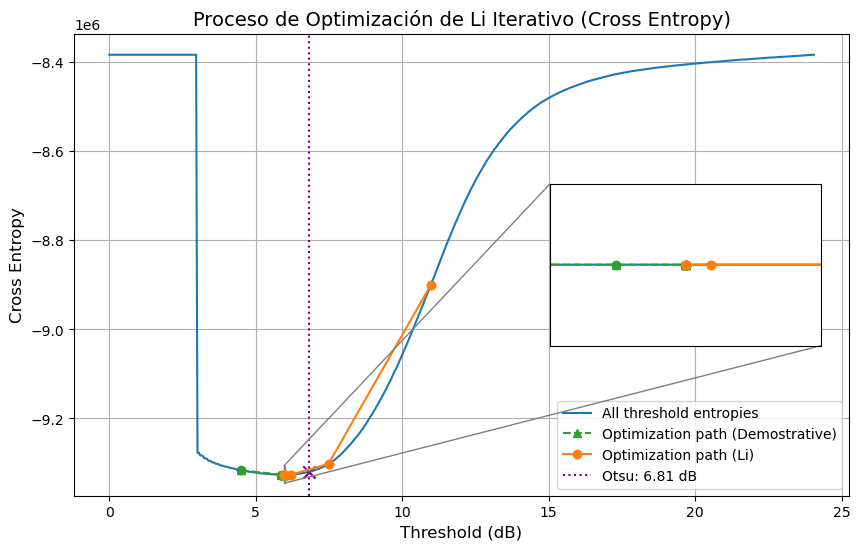

Threshold inicial de Li: 5.9677734375
Threshold optimizado de Li Iterativo: 5.9677734375
  - Otsu         = 6.811
  - Niblack      = 4.432
  - Sauvola      = 4.694
  - Li           = 5.968
  - Li iterativo = 5.968
Creando producto individual para: flood_otsu
Producto creado: flood_otsu
Creando producto individual para: flood_niblack
Producto creado: flood_niblack
Creando producto individual para: flood_sauvola
Producto creado: flood_sauvola
Creando producto individual para: flood_li
Producto creado: flood_li
Creando producto individual para: flood_li_iter
Producto creado: flood_li_iter

Creando producto SNAP para img_db_valid...
Producto SNAP para img_db_valid creado exitosamente.


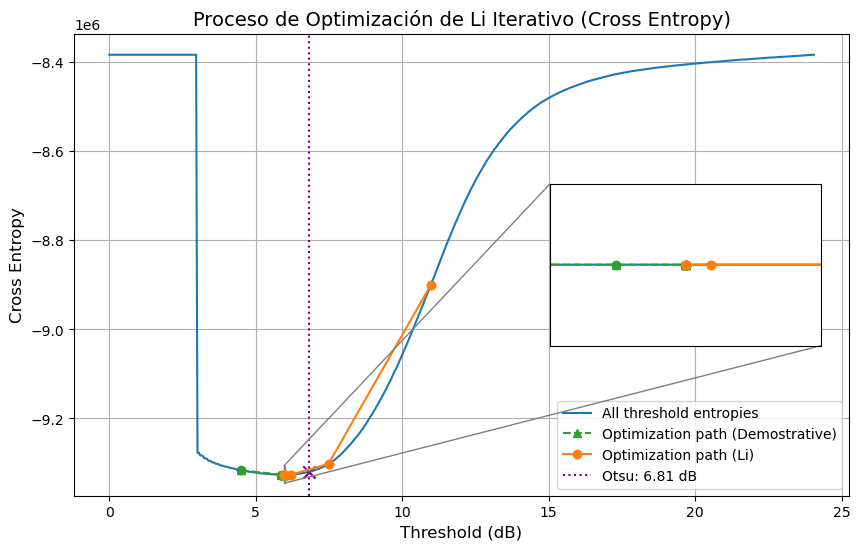

c:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\coastalcf\coastalcf\WDBThreshold.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(loc='lower left', fontsize=10)


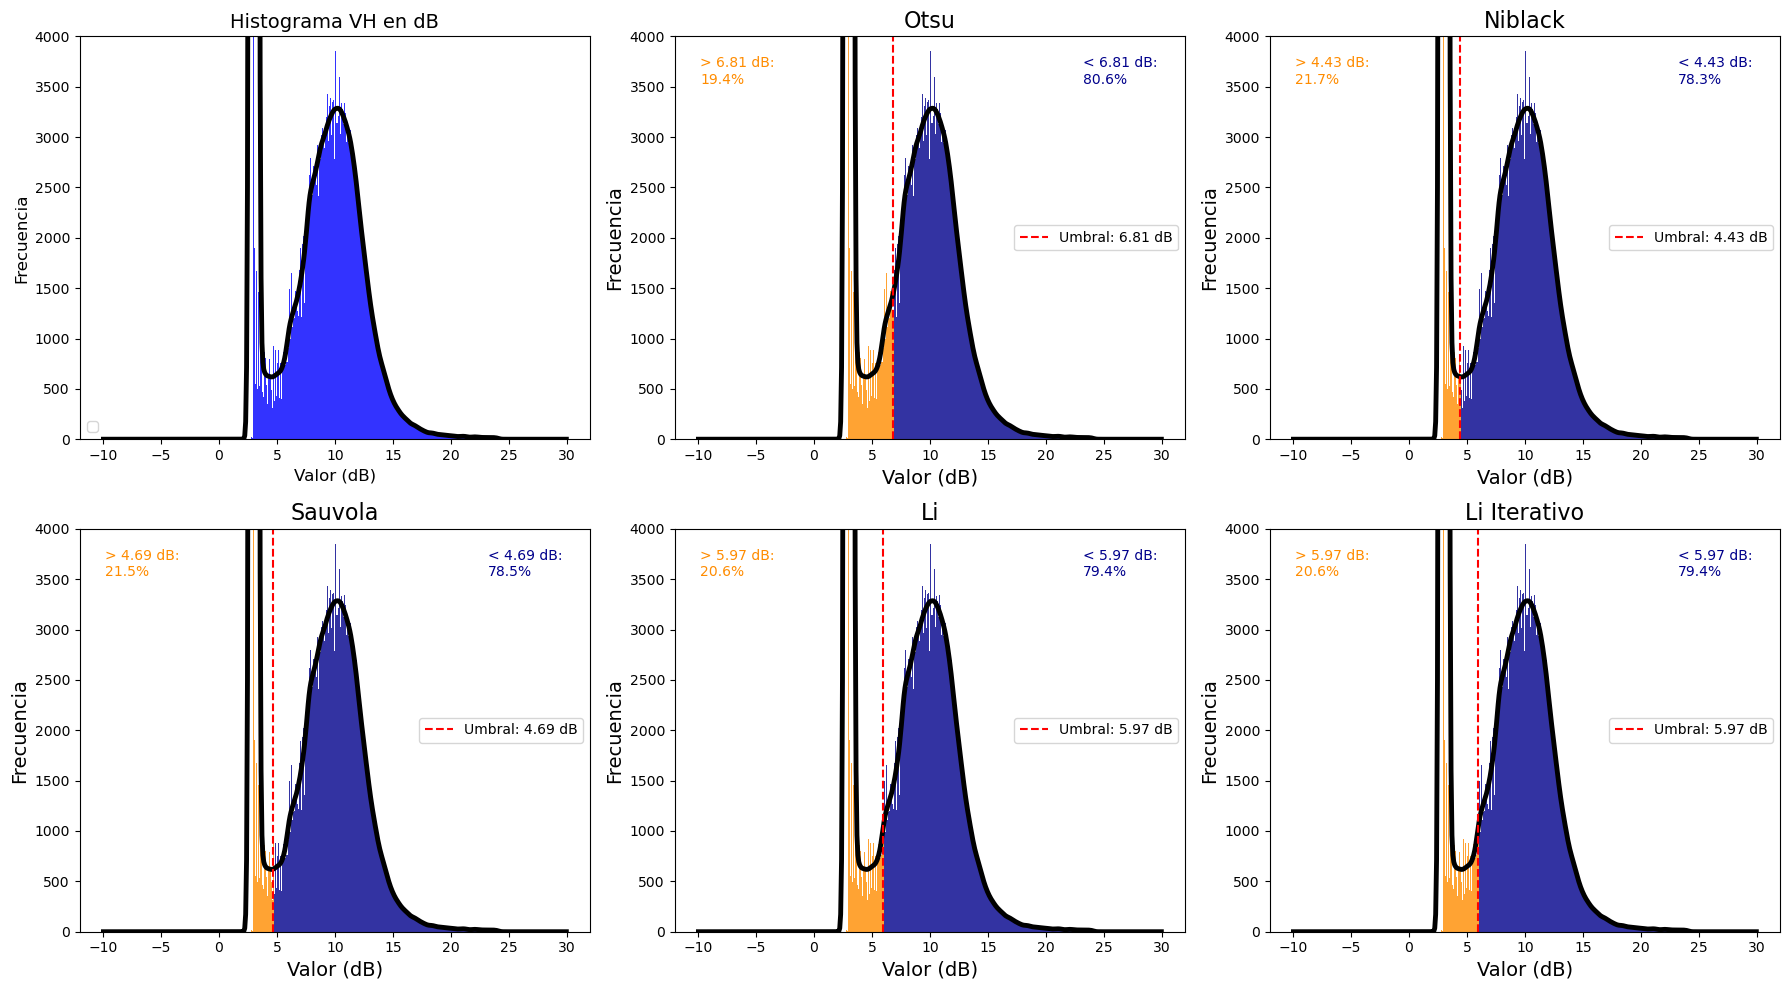

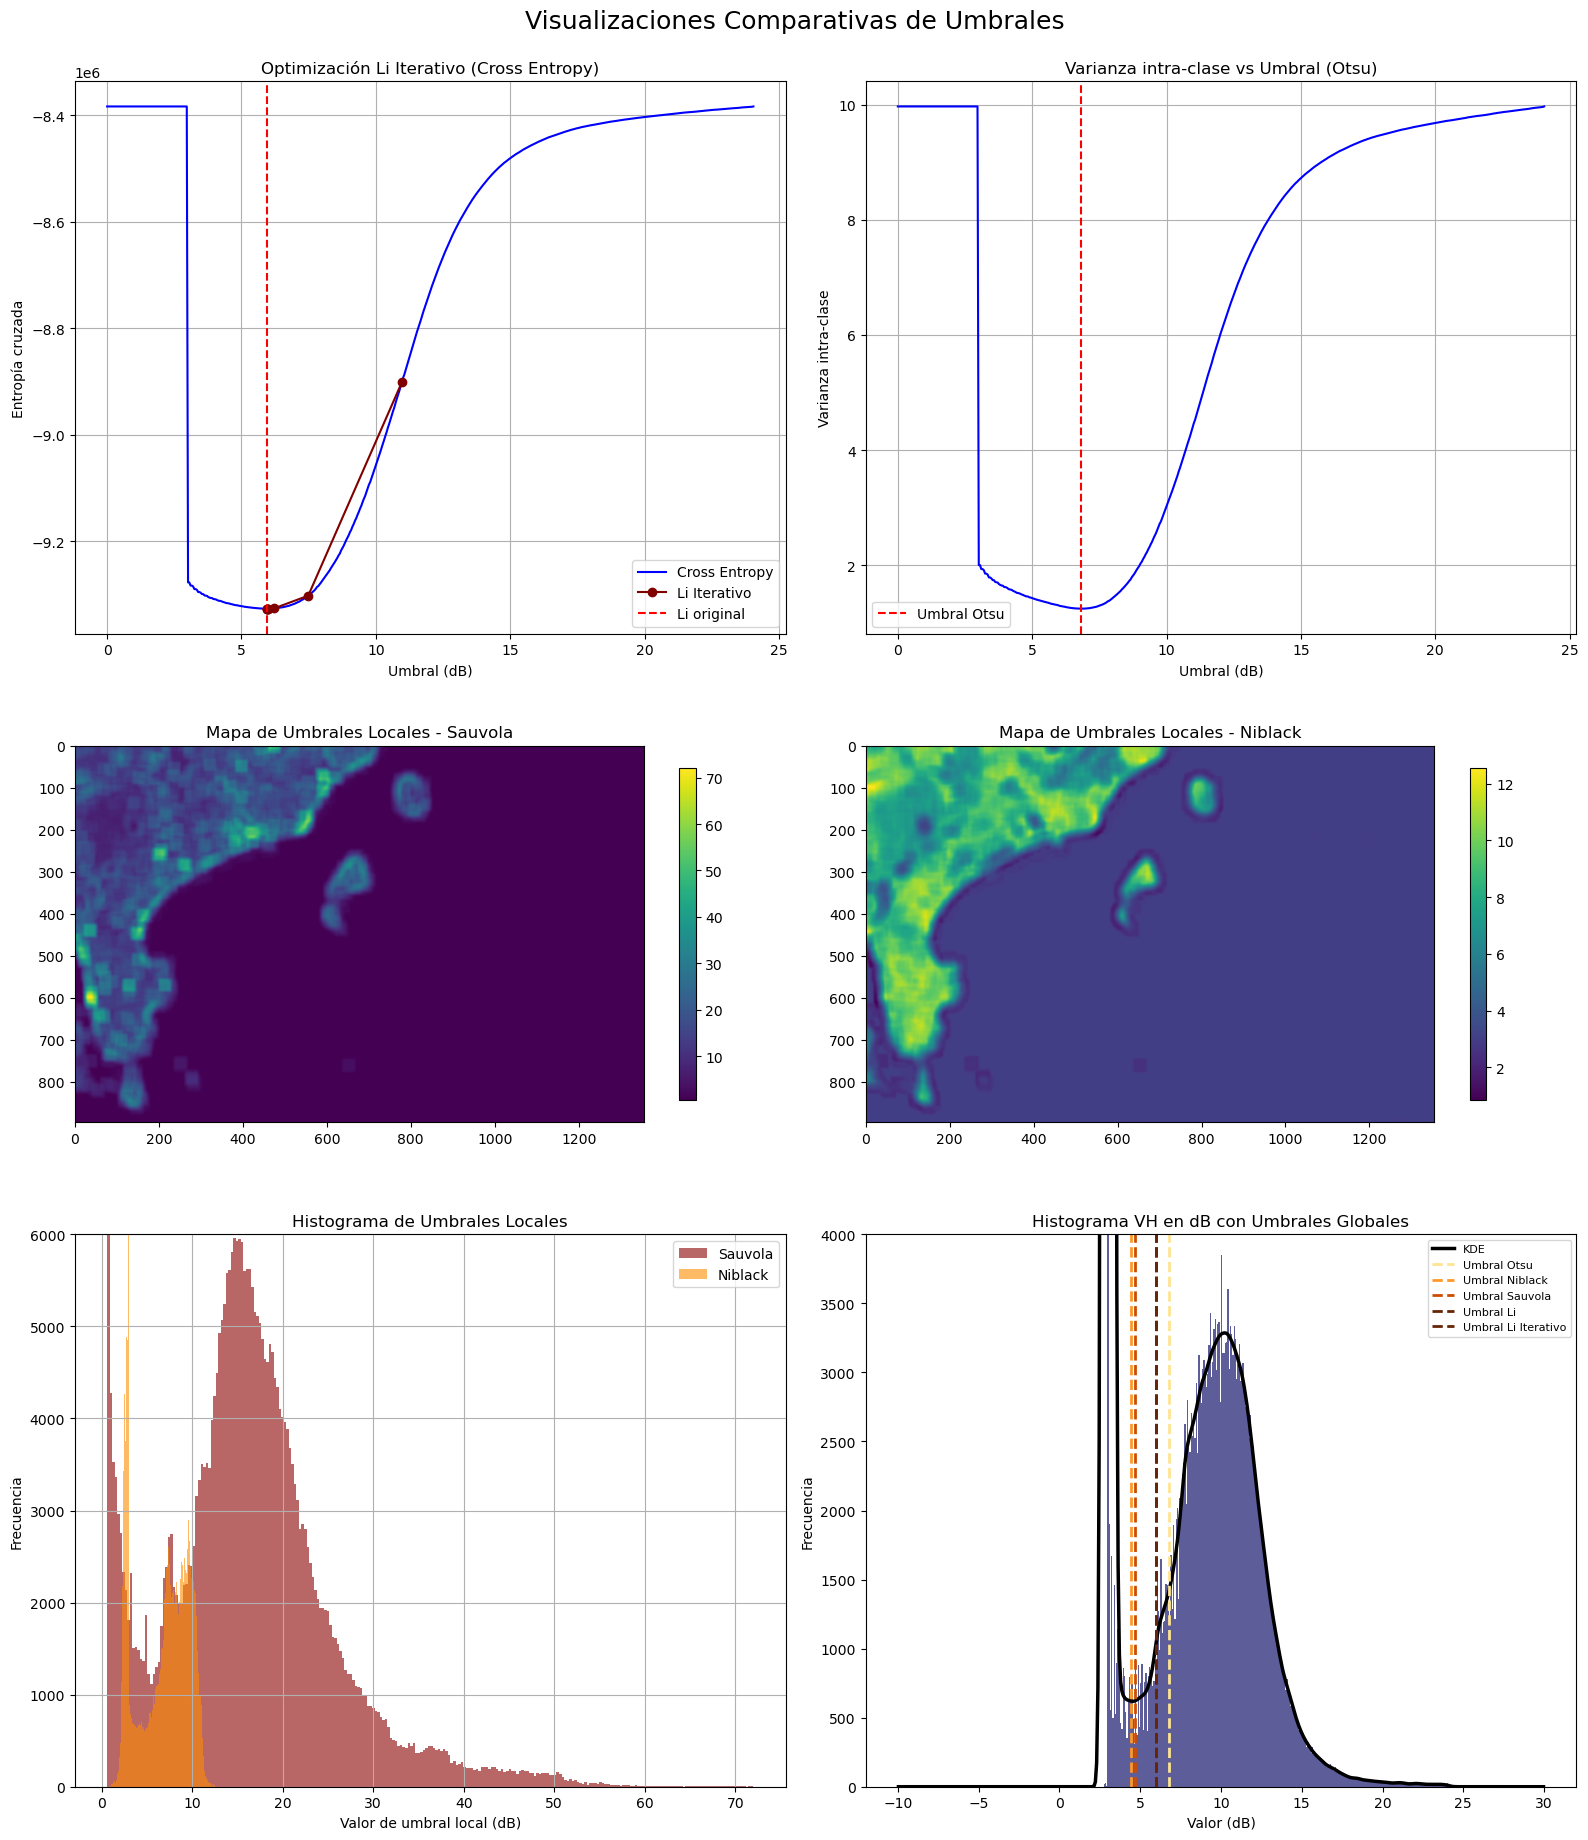

In [4]:
#**************************************************************************

# 8. Umbralización (Método Sauvola) : waterDetectionBinarization [product]
print("Performing water detection...")
productos_binarios, umbrales, img_db_valid = clf.WDBThreshold(
    textura=textura,
    sentinel_1_path=sentinel_1_path,
    window_size=31,
    k=0.2,     # extra param para Niblack/Sauvola
    r=None,     # extra param para Sauvola
    output_dir= output_directory
)

productos_para_graficar = {
    "flood_otsu": (productos_binarios["flood_otsu"], umbrales["otsu"]),
    "flood_niblack": (productos_binarios["flood_niblack"], umbrales["niblack"]),
    "flood_sauvola": (productos_binarios["flood_sauvola"], umbrales["sauvola"]),
    "flood_li": (productos_binarios["flood_li"], umbrales["li"]),
    "flood_li_iter": (productos_binarios["flood_li_iter"], umbrales["li_iterativo"]),
}
#**************************************************************************


Applying terrain correction to all thresholded products...
 -> Corrigiendo: flood_otsu

--- Iniciando corrección geométrica ---
NoData asignado a banda 'flood_otsu' con valor: -1.0
Aplicando corrección geométrica...
Corrección geométrica completada exitosamente.
NoData asignado a banda corregida 'flood_otsu_VH' con valor: -1.0
Bandas resultantes: ['flood_otsu_VH']
Proceso de corrección geométrica finalizado.
 -> Corrigiendo: flood_niblack

--- Iniciando corrección geométrica ---
NoData asignado a banda 'flood_niblack' con valor: -1.0
Aplicando corrección geométrica...
Corrección geométrica completada exitosamente.
NoData asignado a banda corregida 'flood_niblack_VH' con valor: -1.0
Bandas resultantes: ['flood_niblack_VH']
Proceso de corrección geométrica finalizado.
 -> Corrigiendo: flood_sauvola

--- Iniciando corrección geométrica ---
NoData asignado a banda 'flood_sauvola' con valor: -1.0
Aplicando corrección geométrica...
Corrección geométrica completada exitosamente.
NoData asigna

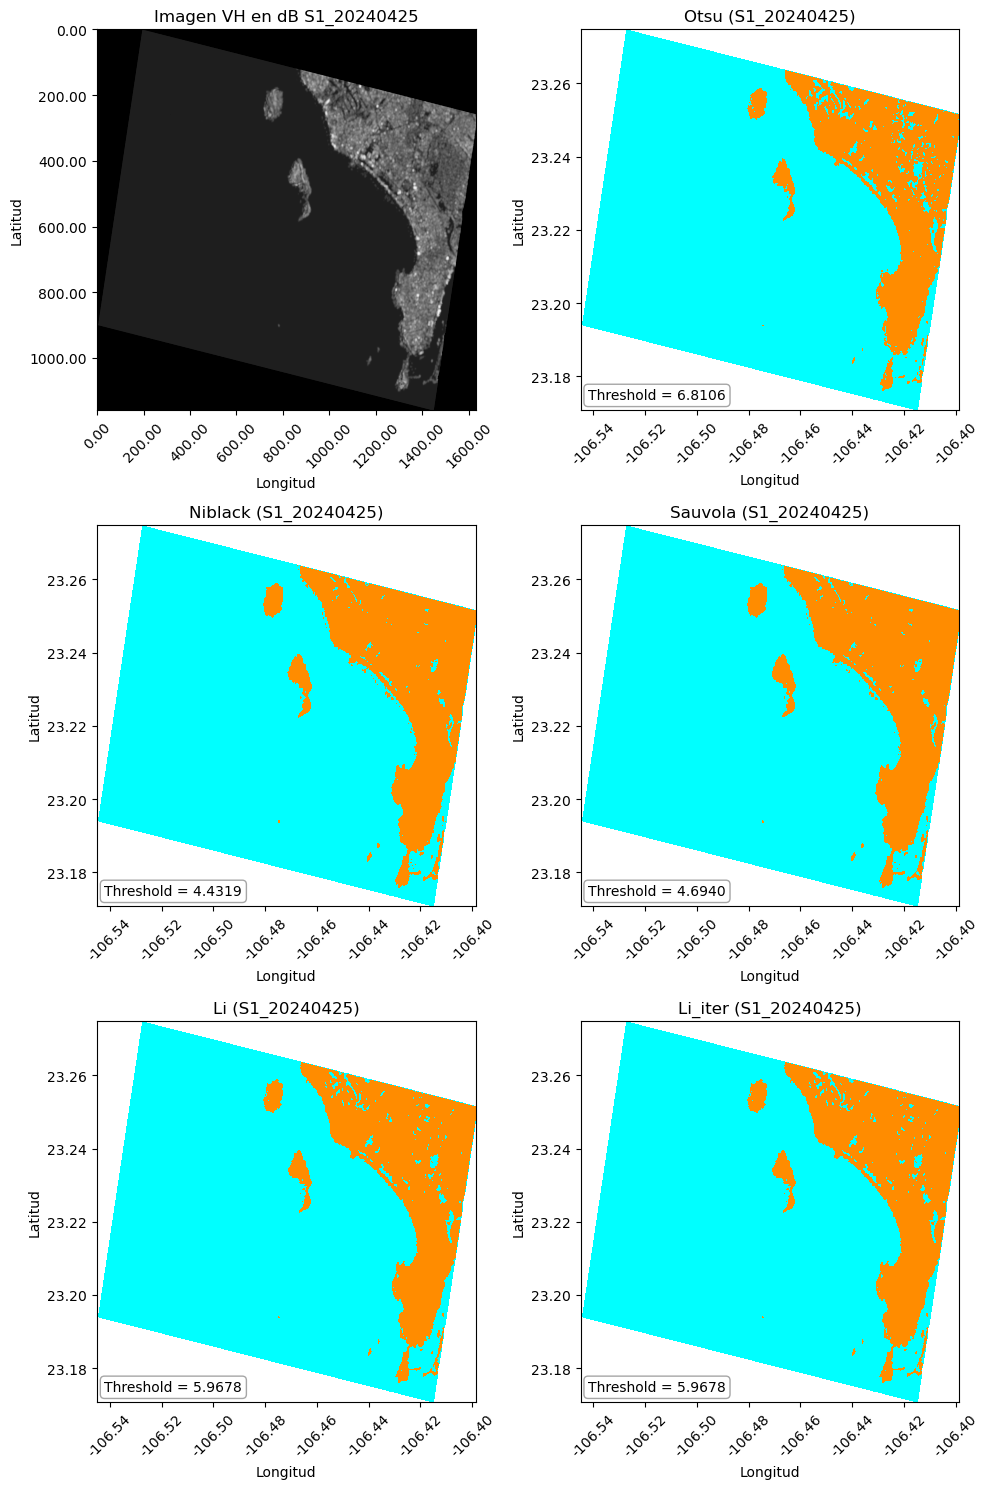

In [5]:
#**************************************************************************


# 9. Corrección geométrica: geometricCorrection [corrected]

print("Applying terrain correction to all thresholded products...")

productos_binarios_corrected = {}
for nombre, (producto, threshold) in productos_para_graficar.items():
    print(f" -> Corrigiendo: {nombre}")
    corregido = clf.geometricCorrection(producto, toPrint=True)
    if corregido is None:
        print(f"⚠️  No se pudo corregir el producto: {nombre}")
    else:
        productos_binarios_corrected[nombre] = (corregido, threshold)

img_db_product = clf.geometricCorrection(img_db_valid, toPrint=True)


# 10. Visualización en grid de productos corregidosprint("\nCreando producto SNAP para img_db_valid...")

from coastalcf.wbplots import aplicar_correccion_y_grid
#aplicar_correccion_y_grid(productos_binarios_corrected, output_directory, sentinel_id)
aplicar_correccion_y_grid(
    productos_binarios=productos_binarios_corrected, 
    output_directory=output_directory,
    sentinel_id="S1_20240425",
    img_db_product=img_db_product#,  # <- tu imagen VH ya en dB
    #vh_extent=[lon_min, lon_max, lat_min, lat_max]  # <- opcional si quieres respetar georeferencia
    )

In [6]:
productos_binarios_corrected
print("Claves disponibles:", productos_binarios_corrected.keys())


Claves disponibles: dict_keys(['flood_otsu', 'flood_niblack', 'flood_sauvola', 'flood_li', 'flood_li_iter'])


In [7]:
primer_producto = next(iter(productos_para_graficar.values()))[0]
print("Bandas disponibles:", list(primer_producto.getBandNames()))


Bandas disponibles: ['flood_otsu']


In [8]:
for nombre, (producto, umbral) in productos_binarios_corrected.items():
    bandas = list(producto.getBandNames())
    print(f"{nombre} → Bandas disponibles: {bandas}")


flood_otsu → Bandas disponibles: ['flood_otsu_VH']
flood_niblack → Bandas disponibles: ['flood_niblack_VH']
flood_sauvola → Bandas disponibles: ['flood_sauvola_VH']
flood_li → Bandas disponibles: ['flood_li_VH']
flood_li_iter → Bandas disponibles: ['flood_li_iter_VH']



--- [flood_otsu] ---
Dimensiones de la imagen: (1159, 1630)
Valores únicos (sin redondear): [-1  0  1] ...
Valores mínimos/máximos: min = -1.00, max = 1.00
Número total de píxeles: 1889170
Píxeles con valor -1: 539237
Píxeles con valor 0: 1087633
Píxeles con valor 1: 262300
Píxeles con valor NaN: 0
Píxeles válidos: 1889170
Umbral para este producto: 6.8106
✅ Exportado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio\VH_flood_otsu_filtered.tif

--- [flood_niblack] ---
Dimensiones de la imagen: (1159, 1630)
Valores únicos (sin redondear): [-1  0  1] ...
Valores mínimos/máximos: min = -1.00, max = 1.00
Número total de píxeles: 1889170
Píxeles con valor -1: 539237
Píxeles con valor 0: 1058070
Píxeles con valor 1: 291863
Píxeles con valor NaN: 0
Píxeles válidos: 1889170
Umbral para este producto: 4.4319
✅ Exportado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio\VH_flood_niblack_filtered.tif

--- [flood_sauvola] ---
Dimensiones de la imagen:

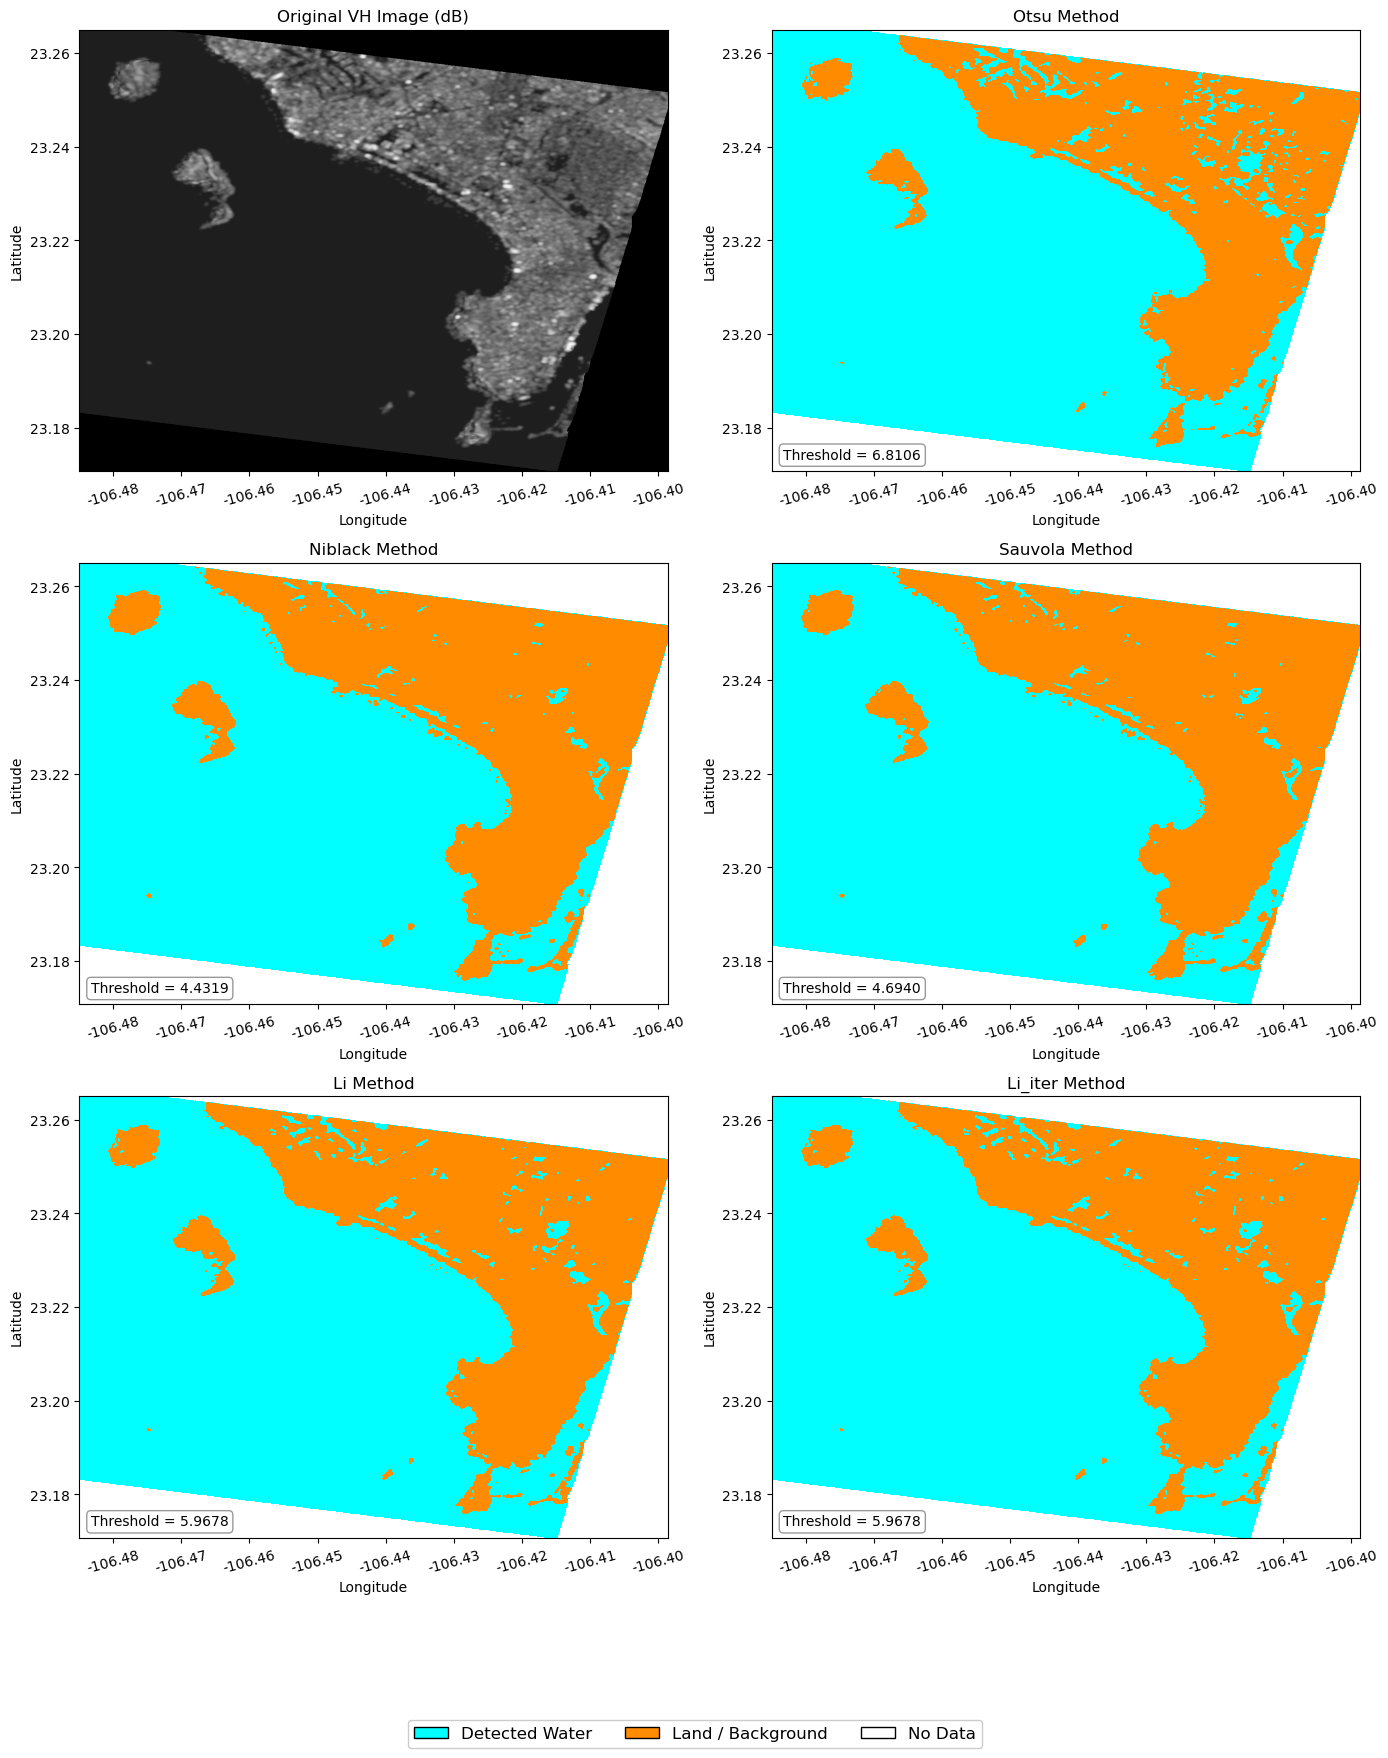

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter
from skimage.morphology import remove_small_objects
from esa_snappy import GeoPos, PixelPos
import os

# Parámetros
object_size = 15
ncols = 2
productos = productos_binarios_corrected
sentinel_id = "VH"
vh_band_name = 'img_db_valid_VH'

# Colormap ternario: -1 = blanco, 0 = agua, 1 = tierra
colors = ['white', 'cyan', 'darkorange']
cmap = ListedColormap(colors)
norm = BoundaryNorm([-1.5, -0.5, 0.5, 1.5], cmap.N)

# Crear figura
fig, axes = plt.subplots(3, 2, figsize=(14, 17))
axes = axes.flatten()

# --- Subplot 0: imagen original VH ---
band = img_db_product.getBand(vh_band_name)
w, h = band.getRasterWidth(), band.getRasterHeight()
img_data = np.zeros(w * h, dtype=np.float32)
band.readPixels(0, 0, w, h, img_data)
img_data = img_data.reshape((h, w))

# Extent geográfico
try:
    geo = img_db_product.getSceneGeoCoding()
    ul, lr = GeoPos(), GeoPos()
    geo.getGeoPos(PixelPos(0, 0), ul)
    geo.getGeoPos(PixelPos(w - 1, h - 1), lr)
    extent = [ul.lon, lr.lon, lr.lat, ul.lat]
except Exception as e:
    print(f"⚠️ No se pudo calcular el extent: {e}")
    extent = None

# Mostrar VH en dB
im0 = axes[0].imshow(img_data, cmap='gray', vmin=0, vmax=25, extent=extent, aspect='auto')
axes[0].set_title('Imagen original VH en dB')
axes[0].set_xlabel('Longitud')
axes[0].set_ylabel('Latitud')

for i, (nombre, (producto, umbral)) in enumerate(productos.items()):
    band_name = f"{nombre}_VH"
    band = producto.getBand(band_name)
    w, h = band.getRasterWidth(), band.getRasterHeight()
    data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, data)
    data = data.reshape((h, w))
    # Redondear a enteros
    data = np.round(data).astype(np.int32)
    print(f"\n--- [{nombre}] ---")
    print(f"Dimensiones de la imagen: {data.shape}")
    print(f"Valores únicos (sin redondear): {np.unique(data)[:10]} ...")  # los 10 primeros únicos
    print(f"Valores mínimos/máximos: min = {np.nanmin(data):.2f}, max = {np.nanmax(data):.2f}")
    print(f"Número total de píxeles: {data.size}")
    print(f"Píxeles con valor -1: {np.sum(data == -1.0)}")
    print(f"Píxeles con valor 0: {np.sum(data == 0.0)}")
    print(f"Píxeles con valor 1: {np.sum(data == 1.0)}")
    print(f"Píxeles con valor NaN: {np.sum(np.isnan(data))}")
    print(f"Píxeles válidos: {np.sum(~np.isnan(data))}")
    print(f"Umbral para este producto: {umbral:.4f}")


    # Paso 1: guardar la máscara de -1
    nodata_mask = (data == -1.0)

    # Paso 2: temporalmente convertimos -1 a 0 (fondo)
    data[nodata_mask] = 0.0
    mask = data.copy()

    # Paso 3: aplicar remove_small_objects sobre agua (0)
    agua_mask = (mask == 0)
    agua_filtrada = remove_small_objects(agua_mask, object_size, connectivity=1)

    # Paso 4: crear máscara final
    final_mask = mask.copy()
    final_mask[(agua_mask) & (~agua_filtrada)] = 1
    final_mask[nodata_mask] = -1

    # Paso 5: graficar
    im = axes[i + 1].imshow(final_mask, cmap=cmap, norm=norm, extent=extent, aspect='auto')

    # Título en inglés
    titulo = nombre.replace("flood_", "").capitalize()
    axes[i + 1].set_title(f'{titulo} Method', fontsize=12)

    # Umbral en caja interna (abajo a la izquierda)
    axes[i + 1].text(
        0.02, 0.02,
        f"Threshold = {umbral:.4f}",
        transform=axes[i + 1].transAxes,
        fontsize=10,
        color='black',
        verticalalignment='bottom',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3', alpha=0.8)
    )
    
    # === Exportar final_mask como GeoTIFF ===
    output_tiff_path = os.path.join(output_directory, f'{sentinel_id}_{nombre}_filtered.tif')

    # Crear transformada a partir del extent [minx, maxx, miny, maxy]
    transform = from_bounds(extent[0], extent[2], extent[1], extent[3], w, h)

    # Convertir -1 a valor de nodata
    export_mask = final_mask.copy()
    export_mask[export_mask == -1] = -9999

    # Guardar como GeoTIFF
    with rasterio.open(
        output_tiff_path,
        'w',
        driver='GTiff',
        height=export_mask.shape[0],
        width=export_mask.shape[1],
        count=1,
        dtype=rasterio.int16,
        crs='EPSG:4326',
        transform=transform,
        nodata=-9999,
        compress='lzw'
    ) as dst:
        dst.write(export_mask.astype(rasterio.int16), 1)

    print(f"✅ Exportado: {output_tiff_path}")


    # Ejes
    axes[i + 1].set_xlabel('Longitude')
    axes[i + 1].set_ylabel('Latitude')
    axes[i + 1].set_xlim(left=-106.485)
    axes[i + 1].tick_params(axis='x', labelrotation=15)

    axes[i + 1].set_ylim(top=23.265)
    axes[i + 1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes[i + 1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# --- Subplot 0 (imagen original en inglés)
axes[0].imshow(img_data, cmap='gray', vmin=0, vmax=25, extent=extent, aspect='auto')
axes[0].set_title('Original VH Image (dB)', fontsize=12)
axes[0].set_xlabel('Longitude')
axes[0].tick_params(axis='x', labelrotation=15)
axes[0].set_ylabel('Latitude')
axes[0].set_xlim(left=-106.485)
axes[0].set_ylim(top=23.265)
axes[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# --- Leyenda en inglés
legend_elements = [
    Patch(facecolor='cyan', edgecolor='k', label='Detected Water'),
    Patch(facecolor='darkorange', edgecolor='k', label='Land / Background'),
    Patch(facecolor='white', edgecolor='k', label='No Data')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, fontsize=12,
           frameon=True, framealpha=1, fancybox=True, bbox_to_anchor=(0.5, -0.06))
# --- Ajustar el layout y mostrar la figura
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.95])  # Ajustar el layout para evitar solapamientos 


# --- Guardar sin título global
plt.savefig(os.path.join(output_directory, f'{sentinel_id}_ThresholdsFiltered.png'), dpi=300)#, bbox_inches='tight')
plt.show()


In [36]:
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape
import numpy as np
import os

def raster_to_shapefile(tiff_path, shapefile_path, target_value=0):
    with rasterio.open(tiff_path) as src:
        image = src.read(1)
        mask = image == target_value  # por ejemplo, agua = 0
        results = (
            {'properties': {'value': v}, 'geometry': s}
            for s, v in shapes(image, mask=mask, transform=src.transform)
        )
        geoms = list(results)
        gdf = gpd.GeoDataFrame.from_features(geoms, crs=src.crs)
        gdf.to_file(shapefile_path)
        print(f"✅ Shapefile saved: {shapefile_path}")


In [ ]:
output_tiff_path
'C:\\Users\\c4cfo\\OneDrive\\CENTROGEO-cfoster\\1_ENSOCE\\thresholdmzt\\6_junio\\VH_flood_li_iter_filtered.tif'

'C:\\Users\\c4cfo\\OneDrive\\CENTROGEO-cfoster\\1_ENSOCE\\thresholdmzt\\6_junio\\VH_flood_li_iter_filtered.tif'

In [39]:
tiff_folder = output_directory#'C:\\Users\\c4cfo\\OneDrive\\CENTROGEO-cfoster\\1_ENSOCE\\thresholdmzt\\6_junio'  # reemplaza con tu carpeta
for nombre in productos.keys():
    tiff_path = os.path.join(tiff_folder, f'{sentinel_id}_{nombre}_filtered.tif')
    shp_path = os.path.join(tiff_folder, f"{sentinel_id}_{nombre}_filtered.shp")
    raster_to_shapefile(tiff_path, shp_path, target_value=1)  # cambiar a 1 si prefieres tierra
    


✅ Shapefile saved: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio\VH_flood_otsu_filtered.shp
✅ Shapefile saved: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio\VH_flood_niblack_filtered.shp
✅ Shapefile saved: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio\VH_flood_sauvola_filtered.shp
✅ Shapefile saved: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio\VH_flood_li_filtered.shp
✅ Shapefile saved: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio\VH_flood_li_iter_filtered.shp


ValueError: num must be an integer with 1 <= num <= 4, not 5

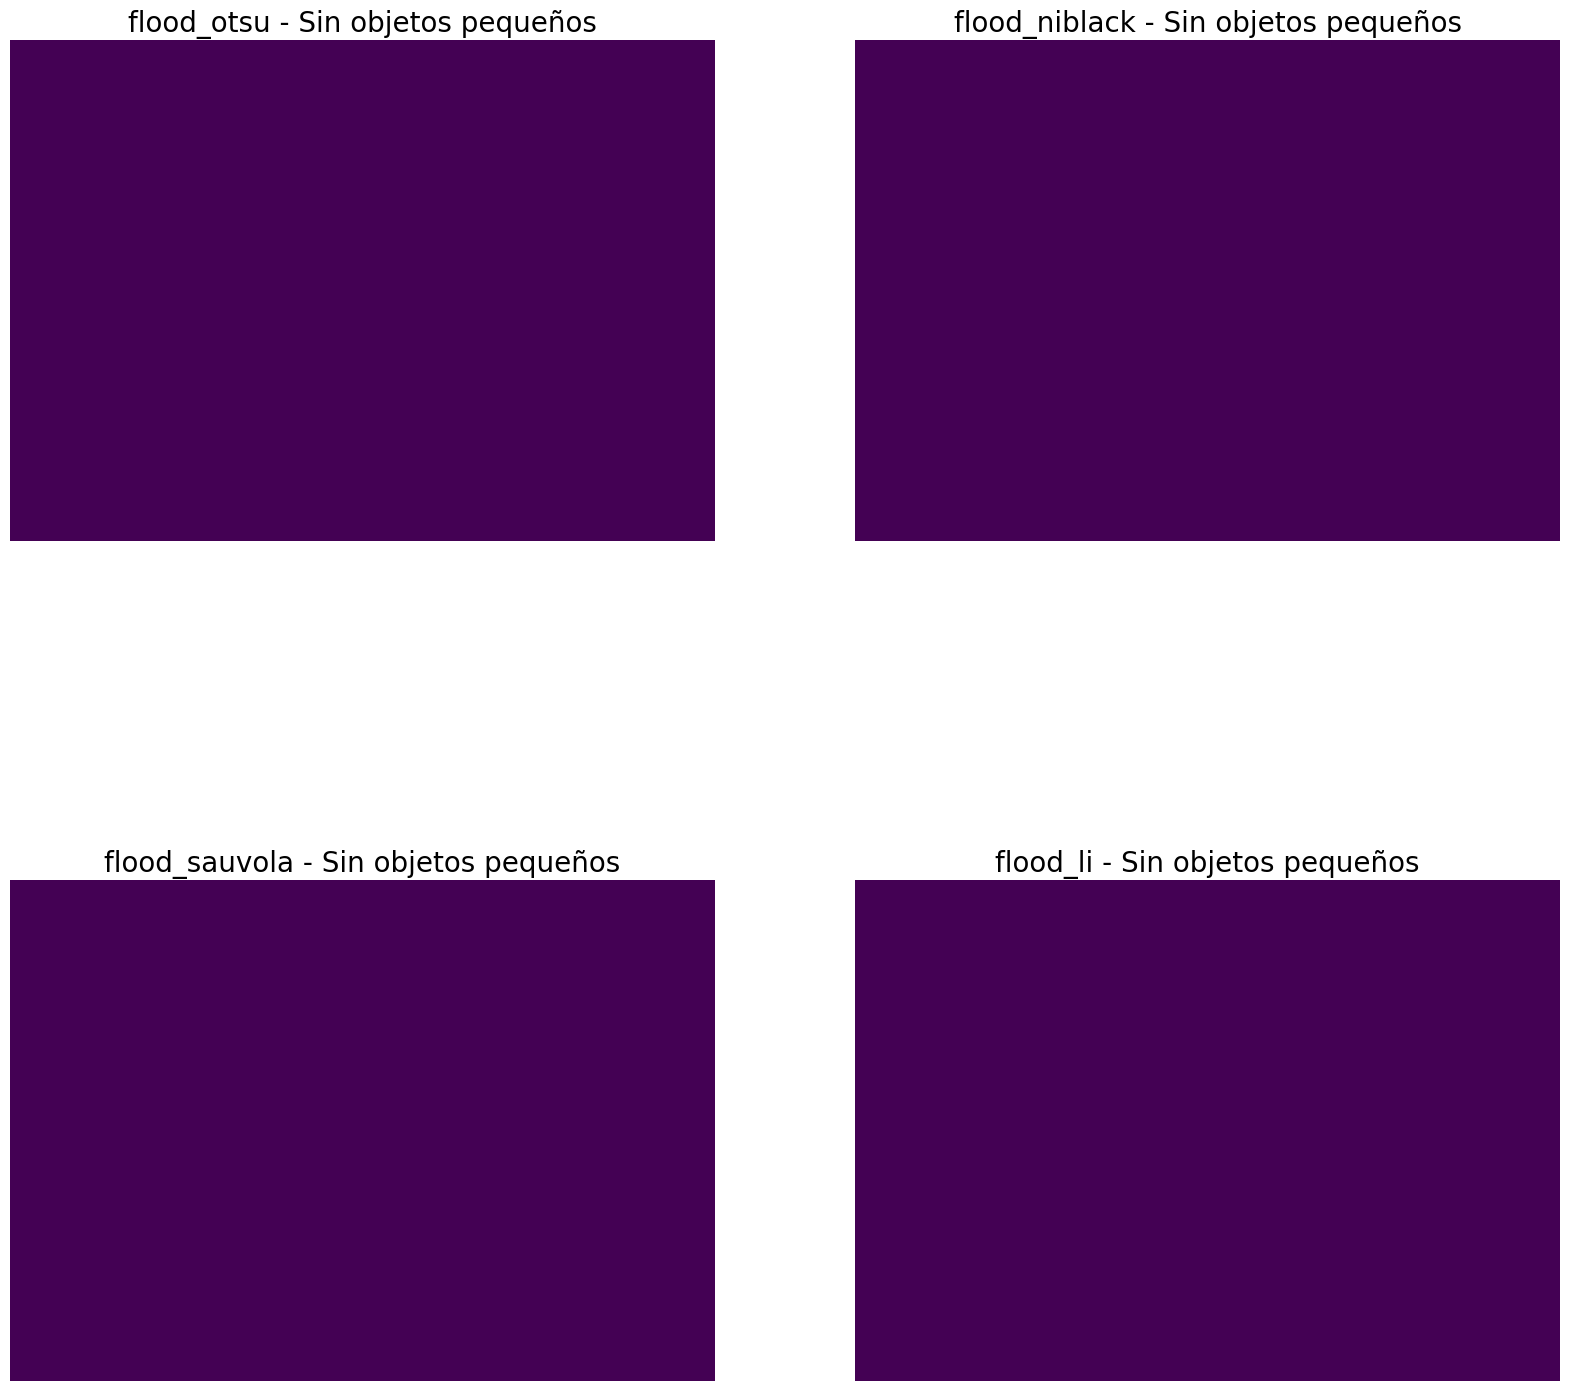

: 

: 

: 

: 

: 

In [ ]:

"""
##---------------------------------------
# 1) Abrir el GeoTIFF en modo solo-lectura
tif_path = final_tif
ds = gdal.Open(tif_path, gdal.GA_ReadOnly)
band = ds.GetRasterBand(1)

# 2) Leer la banda a un array float32
glcm = band.ReadAsArray().astype(np.float32)

# 3) Manejar NoData → NaN
nodata = band.GetNoDataValue()      # debería devolver -9999.0
if nodata is not None:
    glcm[glcm == nodata] = np.nan   # así tu histograma ignora nodata

# 4) ¡Listo!  →  Llamar a la función
thresholds, scores = histograma_threshold_metrics(glcm)
#---------------------------------------------------------
    
for nombre, producto in productos_binarios_corrected.items():
    # Generar sufijos personalizados para cada nombre de producto
    suffix_base = f"_{nombre}_corrected"

    # Generar rutas de salida usando tus funciones reutilizables
    raster_path = clf.generate_raster_path(sentinel_1_path, output_directory)
    shapefile_path = clf.generate_shapefile_path(sentinel_1_path, output_directory)

    print(f"Procesando producto corregido: {nombre}")
    
    # Exportar raster y shapefile
    #clf.exportar_raster_y_shapefile(producto, raster_path, shapefile_path)
"""


"""
for nombre, producto in productos_binarios_corrected.items():
    output_path = os.path.join(output_directory, f"{sentinel_id}_{nombre}_corrected.tif")  
    shape_path = os.path.join(output_directory, f"{sentinel_id}_{nombre}_corrected.shp")  
    print(f"Guardando producto corregido: {output_path}")
    #ProductIO.writeProduct(producto, output_path, "GeoTIFF")  # o "GeoTIFF" si prefieres tif
"""
#extent=[-106.52, -106.41, 23.17, 23.27]
